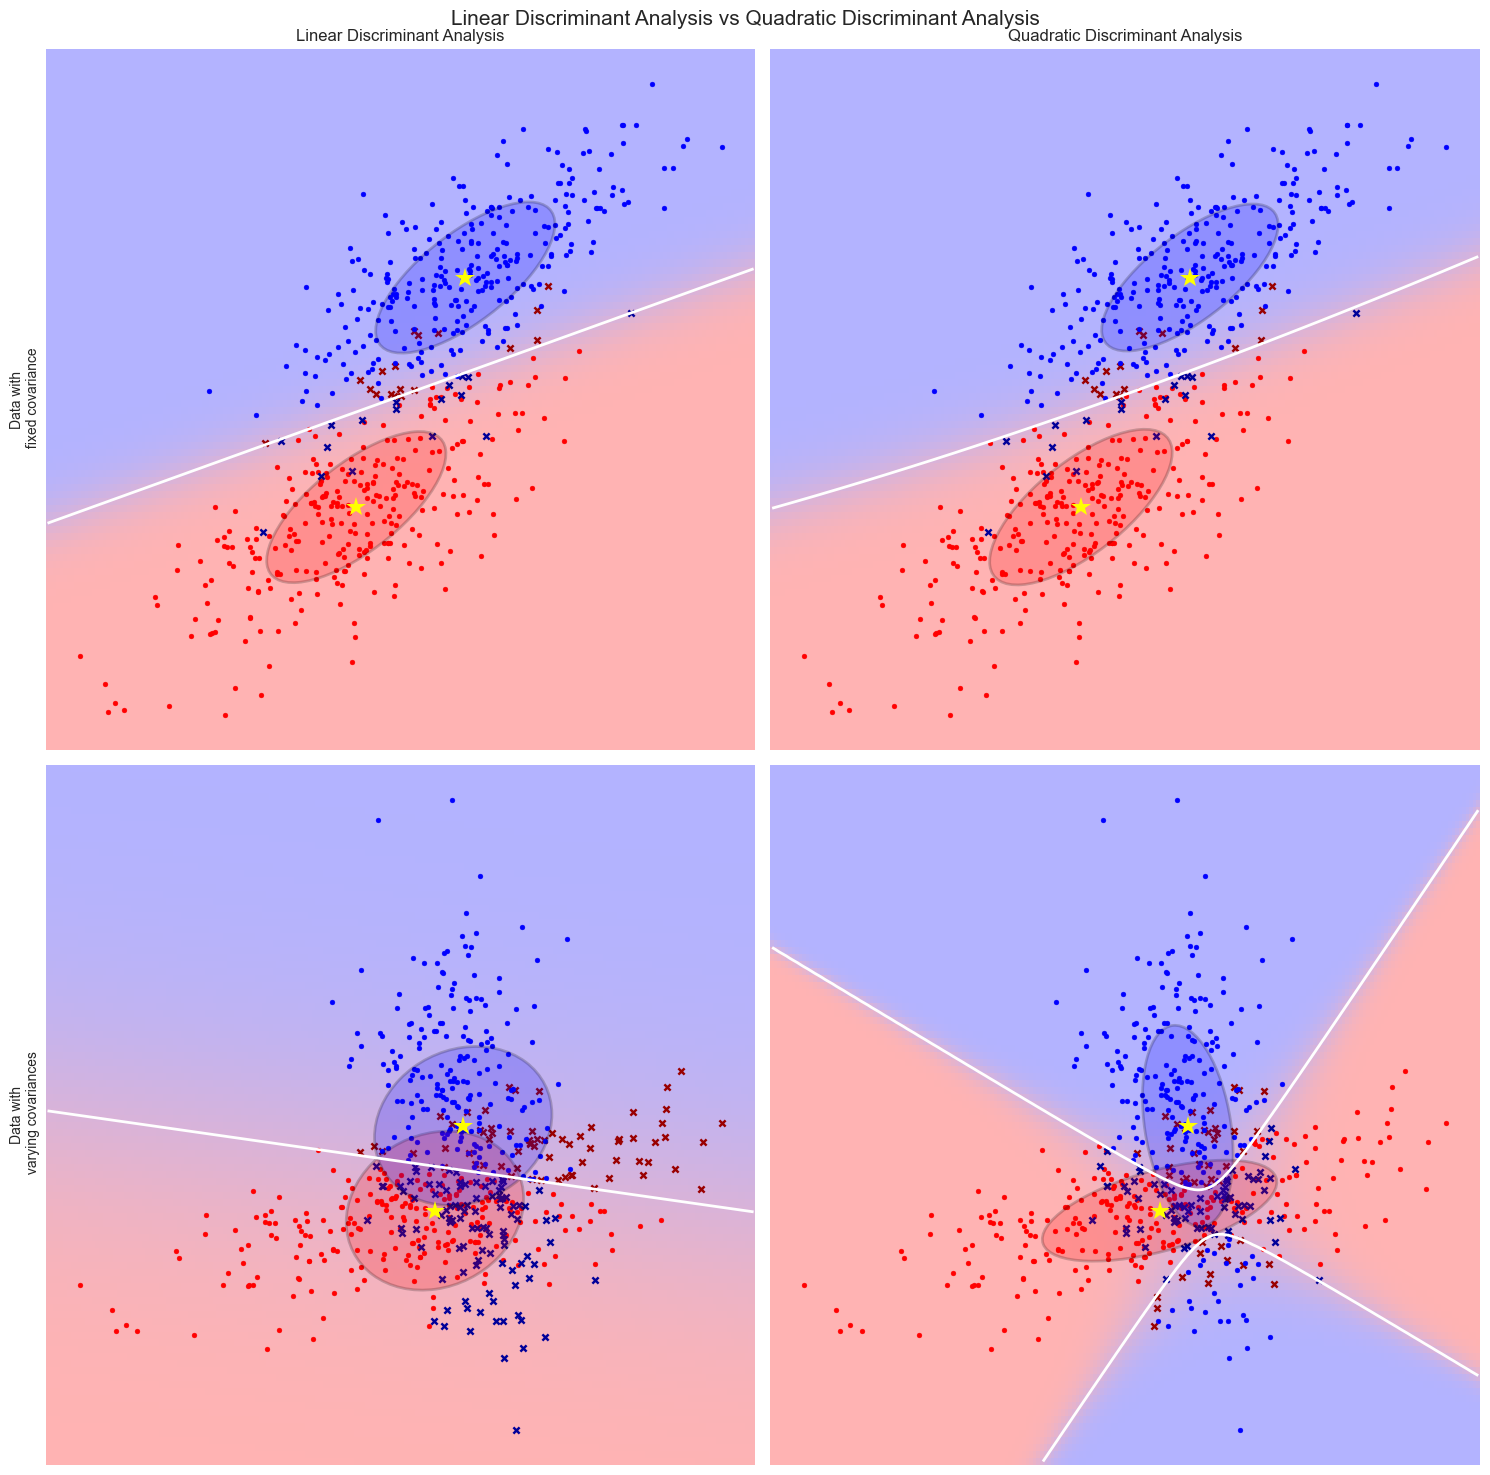

In [1]:
# 导入操作系统库
import os
# 更改工作目录
os.chdir(r"D:\softwares\applied statistics\pythoncodelearning\chap2\sourcecode")
# 导入基础计算库
import numpy as np
# 导入线性计算库
from scipy import linalg
# 导入绘图库
import matplotlib.pyplot as plt
import matplotlib as mpl
# 导入线性和二次判别分析工具
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# 导入绘图库中的字体管理包
from matplotlib import font_manager
# 导入颜色包
from matplotlib import colors
# 实现中文字符正常显示
font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\SimKai.ttf")
# 使用seaborn风格绘图
plt.style.use("seaborn-v0_8")
# 生成数据，来自同一个协方差阵的X，y
def dataset_fixed_cov():
    """Generate 2 Gaussians samples with the same covariance matrix"""
    # 样本量和维度
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -0.23], [0.83, 0.23]])
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C) + np.array([1, 1]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

# 生成数据，来自不同协方差阵的X，y
def dataset_cov():
    """Generate 2 Gaussians samples with different covariance matrices"""
    # 样本量和维度
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y
# 设置颜色
cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
# 添加颜色到cm中
mpl.colormaps.register(cmap=cmap)
# 绘制数据点
def plot_data(lda, X, y, y_pred, fig_index, axs):
    ax = axs.ravel()[fig_index-1]
    if fig_index == 1:
        ax.set_title("Linear Discriminant Analysis")
        ax.set_ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        ax.set_title("Quadratic Discriminant Analysis")
    elif fig_index == 3:
        ax.set_ylabel("Data with\n varying covariances")

    tp = y == y_pred  # True Positive
    # 混淆矩阵的计算
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    ax.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    ax.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    ax.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    ax.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    # LDA概率预测
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # 取出为1的概率
    Z = Z[:, 1].reshape(xx.shape)
    ax.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", 
        zorder=0
    )
    ax.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # 平均值点，0类别
    ax.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    # 平均值点，1类别
    ax.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    return ax

# 绘制椭圆
def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        angle=180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

# 绘制协方差阵，椭圆
def plot_lda_cov(lda, splot):
    plot_ellipse(
        splot, 
        lda.means_[0], # 类别的样本均值
        lda.covariance_, # 类别的样本协方差阵
        "red"
    )
    plot_ellipse(
        splot, 
        lda.means_[1], # 类别的样本均值
        lda.covariance_, # 类别的样本协方差阵
        "blue"
    )


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")


# 开始绘图
fig, axs = plt.subplots(2, 2, figsize=(15,15), tight_layout=True)
plt.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.98,
    fontsize=15,
)
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # 构造线性判别分析模型
    lda = LinearDiscriminantAnalysis(
        solver="svd", # 求解方法
        store_covariance=True # 保存协方差的结果
    )
    # 模型拟合
    lda.fit(X, y)
    # 预测，在训练集上
    y_pred = lda.predict(X)
    # 绘图
    ax = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1, axs=axs)
    # 绘制椭圆，协方差阵
    plot_lda_cov(lda, ax)

    # 建立二次判别分析模型
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    # 模型拟合
    qda.fit(X, y)
    # 预测
    y_pred = qda.predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2, axs=axs)
    plot_qda_cov(qda, splot)

plt.show()
fig.savefig("../codeimage/code1.pdf")
